In [3]:
import numpy as np 
from pathlib import Path
#the line below accesses the file path of the images. Since the main.py file and the archive folder is under the malaria folder, 
#i dont have to write malaria as a part of the file pat
path = Path("archive/cell_images") 
#path.glob gets all the files and folders matching the identifier specified in the argument. it works for with file names,
#and extensions. '*/*.png' includes all subfolders and to not include subfolders its '*.png'
data = list(path.glob('*/*.png'))
uninfected = list(path.glob("Uninfected/*"))
print(len(uninfected))
print(len(data))
print(path.exists())

13780
27558
True


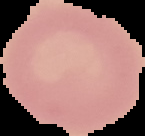

In [4]:
#just wanted to open the images
from PIL import Image
import PIL
PIL.Image.open(uninfected[1])

In [5]:
#resizing images to standardize the data because it leads to more consistentcy from the model
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
#defines transformer and resizes images 
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
#loads dataset
dataset = datasets.ImageFolder(root='archive/cell_images', transform=transform)

#split the data into training, validating, and test. validating is used so we can see how the model looks while its training on it itself
#test is used so we can just test the model without seeing whats going on 
train_size = int(0.8 * len(dataset)) #training data is 80% of the dataset
val_size = len(dataset) - train_size #validating data is 20% of the dataset

#randomly splits the data
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [6]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [7]:
import torch.nn as nn
import torch.nn.functional as func

class NeuralNet(nn.Module):
    def __init__ (self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5) #kernel that scans through the image and creates 12 feature maps
        self.pool = nn.MaxPool2d(2, 2) #creates a 2x2 area that extracts 4 pixels of information and turns it into 1
        self.conv2 = nn.Conv2d(12, 24, 5)
        self.fc1 = nn.Linear(24 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(func.relu(self.conv1(x)))
        x = self.pool(func.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = func.relu(self.fc1(x))
        x = self.fc2(x)
        return x
